### Import libraries as needed

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler, Dataset
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
import copy

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Define helper functions

In [4]:
###########################################################################################

# Function to plot the training and validation accuracy and loss --------------------------
def plot_history(history):
    fig, axs = plt.subplots(2)

    # Create accuracy subplot
    axs[0].plot([acc.cpu().numpy() for acc in history['train_acc']], label="train accuracy")
    axs[0].plot([acc.cpu().numpy() for acc in history['val_acc']], label="validation accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    # Create error subplot
    axs[1].plot(history['train_loss'], label="train error")
    axs[1].plot(history['val_loss'], label="validation error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error Evaluation")

    plt.show()

###########################################################################################

# Function to visualize some images before you train --------------------------------------
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp, cmap='gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

############################################################################################

# Function to visualize sample count before split ------------------------------------------
def plot_class_distribution(counts_dict, title):
    # Get class names and counts
    classes = list(counts_dict.keys())
    counts = list(counts_dict.values())

    # Create bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, color='skyblue')
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.title(title)
    plt.show()

############################################################################################

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues');
    plt.ylabel('Actual Label');
    plt.xlabel('Predicted Label');
    plt.title('Confusion Matrix', size=15);
    plt.show()

############################################################################################

# Function for classification report for perfomance metrics
from sklearn import preprocessing
def calculate_metrics(y_true, y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_true)
    class_names = [str(cls) for cls in le.classes_]
    print(classification_report(y_true, y_pred, target_names=class_names))

############################################################################################


### Define function to **train** the model

In [5]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Initialize the history
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Train', 'Validation']:
            if phase == 'Train':
                model.train()  # Set model to training mode
                print("training phase")
            else:
                model.eval()   # Set model to evaluate mode
                print("eval phase")

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'Train':
                scheduler.step()

            # epoch_loss = running_loss / dataset_sizes[phase]
            # epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), f'bestmodel_effnet_b7.pth')

            # Save the loss and accuracy in history
            if phase == 'Train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history


### Load data, setup dataloaders, and visualize sample counts

In [6]:
# Define transformations for the training set
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.RandomResizedCrop(48, scale=(0.95, 1.05)),  # ±5% image zooms
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

# Define transformations for the validation and test sets
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

train_dir = '/content/drive/MyDrive/645 - Deep Learning/Final Project/train'
test_dir = '/content/drive/MyDrive/645 - Deep Learning/Final Project/test'

# Load the datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=val_test_transform)

In [7]:
# Split the test data into validation and test sets
file_names = [item[0] for item in test_data.imgs]
public_files = [name for name in file_names if 'Public' in name]
private_files = [name for name in file_names if 'Private' in name]

public_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Public' in img_path]
private_indices = [i for i, (img_path, _) in enumerate(test_data.imgs) if 'Private' in img_path]

validation_data = torch.utils.data.Subset(test_data, public_indices)
test_data = torch.utils.data.Subset(test_data, private_indices)

# Create data loaders
batch_size = 128
num_workers = 2
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
validation_loader = DataLoader(validation_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataloaders = {
    'Train': train_loader,
    'Validation': validation_loader,
    'Test': test_loader
}

In [8]:
print("Length of Train Loader: ", len(dataloaders['Train']))
print("Length of Validation Loader: ", len(dataloaders['Validation']))

Length of Train Loader:  183
Length of Validation Loader:  23


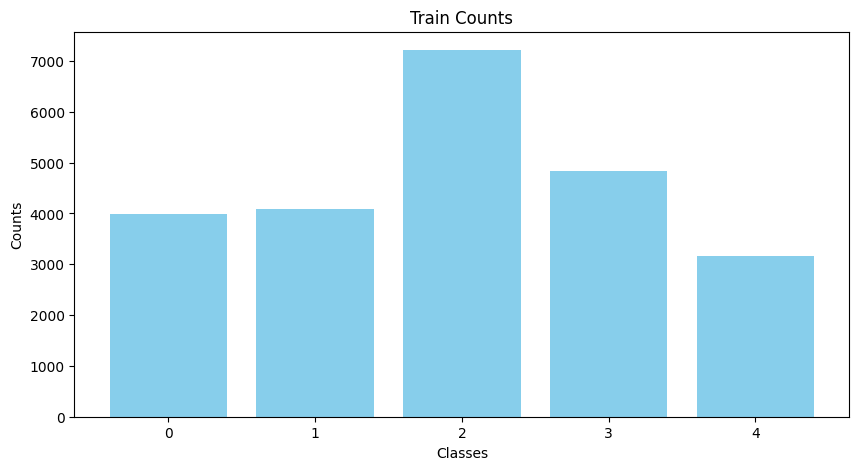

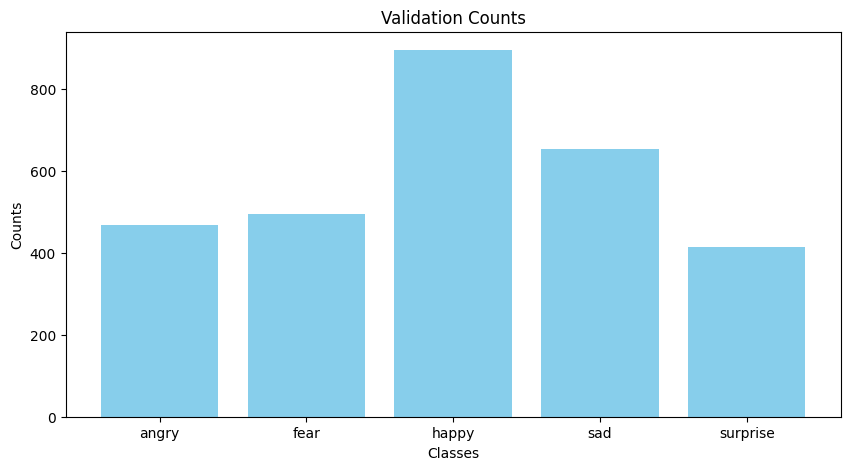

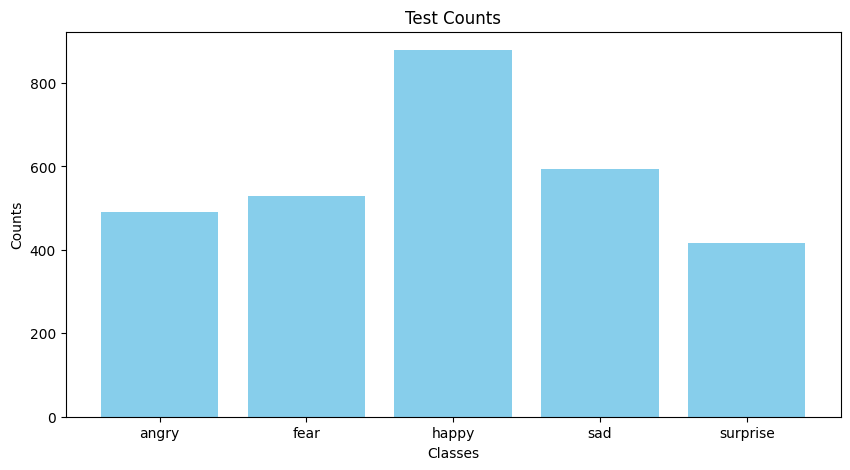

In [9]:
# Get the class names
class_names = train_data.classes

# Create a dictionary mapping indices to class names
idx_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Count labels in the original dataset for train
original_counts = Counter(train_data.targets)

# Count labels in the subsets
valid_counts = Counter(test_data.dataset.targets[i] for i in public_indices)
test_counts = Counter(test_data.dataset.targets[i] for i in private_indices)

# Plot
plot_class_distribution(original_counts, 'Train Counts')
plot_class_distribution({idx_to_class[i]: count for i, count in valid_counts.items()}, 'Validation Counts')
plot_class_distribution({idx_to_class[i]: count for i, count in test_counts.items()}, 'Test Counts')

####Data seems to be imbalanced with happy class having a lot more data, remaining classes seem to be somewhat equal

### Visualize some sample from the training set before training

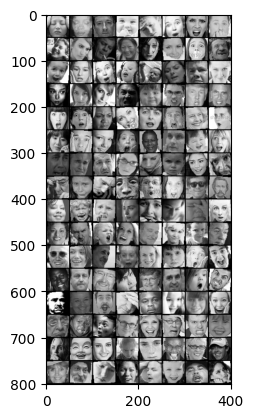

In [10]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

### Import ResNet50 model and freeze layers + replace classifier to match our number of classes and some basic fc layers with ReLU and end with a softmax activation

Define loss function, step optimizer, learning rate scheduler

In [11]:
# # Define the criterion
# # criterion = nn.CrossEntropyLoss()
# criterion = nn.NLLLoss() # try this first

# # Define the optimizer (only the parameters of the classifier will be optimized)
# optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# # Define the learning rate scheduler
# scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model
model = models.densenet121(pretrained=True)
model.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Freeze the layers
for param in model.parameters():
    param.requires_grad = False

# Replace the classifier
num_ftrs = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 1024),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(1024, 5),
    nn.LogSoftmax(dim=1)
)

# Move the model to GPU if available
model = model.to(device)

# Define the criterion
criterion = nn.NLLLoss()  # Compatible with nn.LogSoftmax as the final layer

# Define the optimizer (only the parameters of the classifier will be optimized)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)

# Define the learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 106MB/s]


In [12]:
print(f"Using device: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))


Using device: cuda
Tesla T4


### Train the model

In [13]:
model, history = train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=30)

Epoch 0/29
----------
training phase
Train Loss: 1.5804 Acc: 0.2959
eval phase
Validation Loss: 1.5496 Acc: 0.3192

Epoch 1/29
----------
training phase
Train Loss: 1.5512 Acc: 0.3134
eval phase
Validation Loss: 1.5345 Acc: 0.3237

Epoch 2/29
----------
training phase
Train Loss: 1.5350 Acc: 0.3235
eval phase
Validation Loss: 1.5253 Acc: 0.3195

Epoch 3/29
----------
training phase
Train Loss: 1.5282 Acc: 0.3269
eval phase
Validation Loss: 1.5158 Acc: 0.3243

Epoch 4/29
----------
training phase
Train Loss: 1.5202 Acc: 0.3332
eval phase
Validation Loss: 1.5118 Acc: 0.3390

Epoch 5/29
----------
training phase
Train Loss: 1.5169 Acc: 0.3371
eval phase
Validation Loss: 1.5073 Acc: 0.3380

Epoch 6/29
----------
training phase
Train Loss: 1.5128 Acc: 0.3387
eval phase
Validation Loss: 1.5050 Acc: 0.3363

Epoch 7/29
----------
training phase
Train Loss: 1.5107 Acc: 0.3379
eval phase
Validation Loss: 1.5032 Acc: 0.3353

Epoch 8/29
----------
training phase
Train Loss: 1.5070 Acc: 0.3404
eval

### Plot the loss and accuracy values during training for the train and validation sets

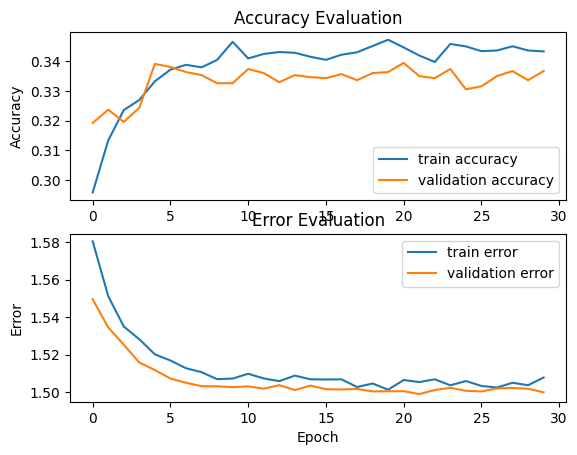

In [14]:
# Plot the history
plot_history(history)

### Plot performance metrics such as accuracy, precision, recall and f1-score as well as the **Confusion Matrix**

In [15]:
# Get predictions for the test set
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


In [16]:
# Calculate metrics
calculate_metrics(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.34      0.06      0.10       491
           1       0.25      0.07      0.11       528
           2       0.37      0.81      0.50       879
           3       0.33      0.29      0.31       594
           4       0.43      0.23      0.30       416

    accuracy                           0.36      2908
   macro avg       0.34      0.29      0.26      2908
weighted avg       0.34      0.36      0.29      2908



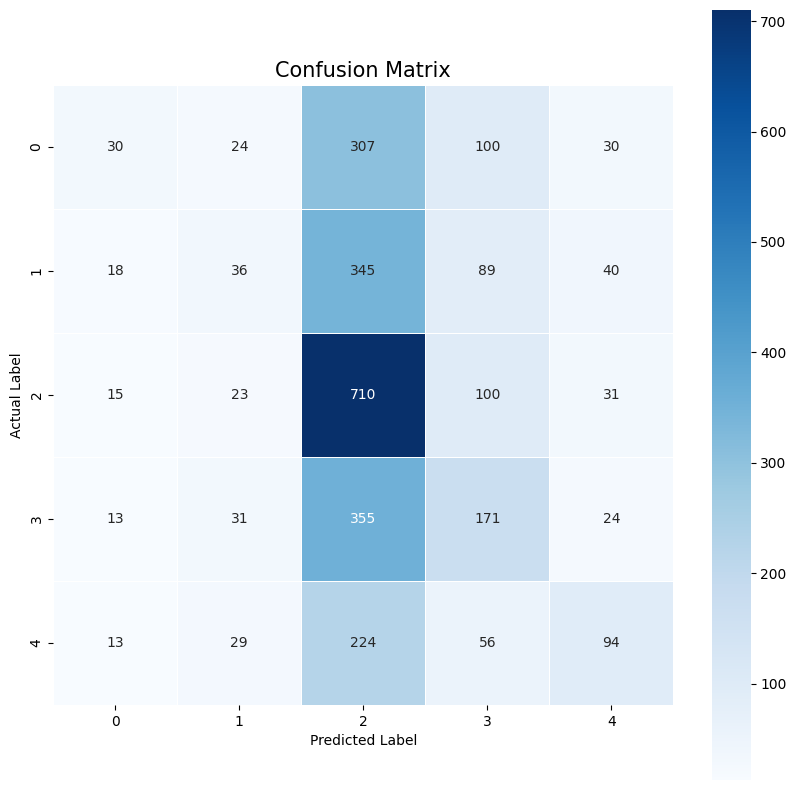

In [17]:
# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred)